In [277]:
%pylab inline
import json
import seaborn as sns
from matplotlib import ticker
import re
from tqdm import tqdm_notebook as tqdm
from matplotlib.patches import Rectangle

Populating the interactive namespace from numpy and matplotlib


In [44]:
!cat /ubc/cs/research/arrow/newmanne/positronic-economist/metrics/* > /ubc/cs/research/arrow/newmanne/positronic-economist/all.metrics
lines = read_lines('/ubc/cs/research/arrow/newmanne/positronic-economist/all.metrics')
lines = map(json.loads, lines)
df = pd.DataFrame.from_records(lines)

In [45]:
df.columns

Index([u'BBSI-CPU', u'BBSI-SE-CPU', u'BBSI-SE-size', u'BBSI-SE-time',
       u'BBSI-size', u'BBSI-time', u'BNFG-size', u'Post-WBSI size',
       u'WBSI-CPU', u'WBSI-time', u'bbsi_level', u'dir', u'game', u'n_players',
       u'name', u'prepro-CPU', u'prepro-time', u'seed'],
      dtype='object')

In [46]:
df['bad'] = df['game'].apply(lambda game: 'bad' in game)
def summer(wbsi,bbsi,bad):
    if not bad:
        return bbsi
    else:
        return wbsi + bbsi
df['BBSI-CPU'] = np.vectorize(summer)(df['BBSI-CPU'], df['WBSI-CPU'], df['bad'])

In [324]:
def to_nice_name(g):
    return {
        'gsp': 'wGSP',
        'gfp': 'GFP',
        'two_approval': '2-approval',
        '2-approval': '2-approval',
        'bad_two_approval': '2-approval',
        'bad_gfp': 'GFP',
        'GFP': 'GFP',
        'wGSP': 'wGSP',
        'bad_gsp': 'wGSP',
    }[g.lower()]

def medianer(x):
    x['runtime'] = x['runtime'].median()
    x = x.drop(['gnm_seed', 'result'], axis=1)
    x = x.drop_duplicates()
    if len(x) > 1:
        display(x)
    return x


In [325]:
def alg_runs_to_melt(df):
    #gnm[(gnm['game'] == 'gfp') & (gnm['n_players'] == 10)]['result'].value_counts()
    melt = df.groupby(['game', 'n_players', 'posec_seed', 'bad', 'config']).apply(medianer)
    melt = pd.melt(melt, id_vars=['n_players', 'game', 'config'], value_vars='runtime')
    melt.rename(columns={'config':'type', 'n_players': 'Number of agents'}, inplace=True)
    melt['game'] = melt['game'].map(to_nice_name)
    return melt

In [326]:
gnm = pd.read_csv('gnm.csv')
ibr = pd.read_csv('ibr.csv')
gnm_melt = alg_runs_to_melt(gnm)
ibr_melt = alg_runs_to_melt(ibr)


In [319]:
N = 'Number of agents'
SIZE = "size"
RUNTIME = 'runtime'

In [48]:


runtimes = pd.melt(df, id_vars=['game', 'n_players', 'bbsi_level', 'bad'], value_vars=['WBSI-CPU', 'BBSI-CPU'])
runtimes['metric'] = RUNTIME
sizes = pd.melt(df, id_vars=['game', 'n_players', 'bbsi_level', 'bad'], value_vars=['BNFG-size', 'Post-WBSI size', 'BBSI-size'])
sizes['metric'] = SIZE
df3 = pd.concat([sizes, runtimes])
def classify(variable, bad):
    if bad:
        return 'BBSI'
    else:
        if 'WBSI' in variable:
            return 'WBSI'
        elif 'BBSI' in variable:
            return 'WBSI + BBSI'
        else:
            return 'NFG'
    
df3 = df3[~((df3['bad']) & (df3['variable'].isin(['BNFG-size', 'Post-WBSI size', 'WBSI-CPU'])))]

df3['type'] = np.vectorize(classify)(df3['variable'], df3['bad'])
df3.rename(columns={'n_players': N}, inplace=True)
df3['game'] = df3['game'].map(to_nice_name)


In [184]:
sns.set(font_scale=2)  
order = ['NFG', 'WBSI', 'WBSI + BBSI', 'BBSI']
palette = sns.color_palette("Set1", len(order))
palette_dict = {order[i]:palette[i] for i in range(len(order))}

In [ ]:
# # sns.set_style('ticks')
# # sns.set_style("darkgrid", {'xtick.color': '.15',
# #  'ytick.color': '.15',
# #  'ytick.direction': 'out',
# #  'ytick.major.size': 6.0,
# #  'ytick.minor.size': 3.0})

# def do_plot(d, extra=None,metric=None):
#     highest = d['value'].max()
#     lowest = d['value'].min()
#     for game, group in d.groupby('game'):
#         plt.figure(figsize=(9,6))                    
#         if metric == 'runtime':
#             order_copy = list(order)
#             order_copy.remove('NFG')
#         else:
#             order_copy = order
#         sns.boxplot(x=N, y='value', data=group, hue='type', palette=palette_dict, linewidth=0.6, hue_order=order_copy)
#         plt.yscale('log')
#         if metric == 'size':
#             plt.ylabel('Size (payoffs)')
#         else:
#             plt.ylabel('Time (s)')
#         plt.ylim(ymin=lowest / 10, ymax=highest*10)

#         plt.legend(loc='upper left')
#         plt.title(game)
#         plt.tight_layout()
#         sns.despine(right=True)
#         figname = 'figures/%s_%s.png' % (game, metric)
#         if extra is not None:
#             figname = 'figures/%s_%s_%s.png' % (game, extra, metric)
#         print "saving", figname
#         plt.savefig(figname, dpi=300)


# # do_plot(gnm_melt, extra='gnm',metric='runtime')
        
# # Simpler plots
# for metric in ['size', 'runtime']:
#     d = df3[df3['metric'] == metric]
#     if len(d) > 0:
#         do_plot(d, metric=metric)

2 TIMEOUT for gnm 2-approval WBSI with 4 players
7 TIMEOUT for gnm 2-approval WBSI with 5 players
9 TIMEOUT for gnm 2-approval WBSI with 6 players
10 TIMEOUT for gnm 2-approval WBSI with 7 players
10 TIMEOUT for gnm 2-approval WBSI with 8 players
10 TIMEOUT for gnm 2-approval WBSI with 9 players
10 TIMEOUT for gnm 2-approval WBSI with 10 players
2 TIMEOUT for gnm 2-approval WBSI + BBSI with 4 players
7 TIMEOUT for gnm 2-approval WBSI + BBSI with 5 players
9 TIMEOUT for gnm 2-approval WBSI + BBSI with 6 players
10 TIMEOUT for gnm 2-approval WBSI + BBSI with 7 players
10 TIMEOUT for gnm 2-approval WBSI + BBSI with 8 players
10 TIMEOUT for gnm 2-approval WBSI + BBSI with 9 players
10 TIMEOUT for gnm 2-approval WBSI + BBSI with 10 players
4 TIMEOUT for gnm 2-approval BBSI with 4 players
6 TIMEOUT for gnm 2-approval BBSI with 5 players
saving figures/2-approval_gnm_runtime.png
1 TIMEOUT for gnm GFP WBSI with 4 players
1 TIMEOUT for gnm GFP WBSI + BBSI with 4 players
1 TIMEOUT for gnm GFP BB

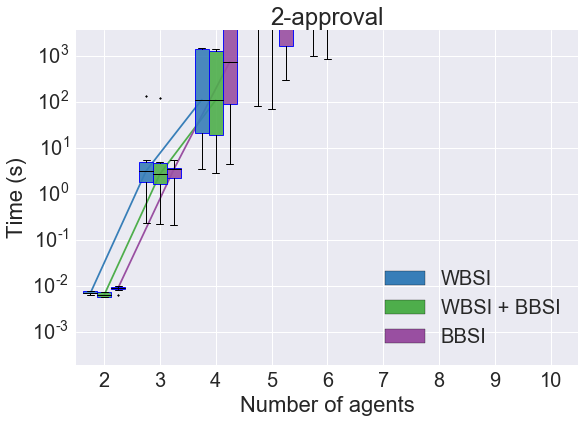

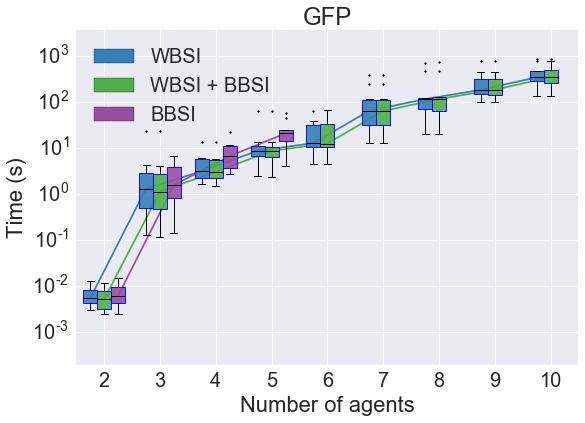

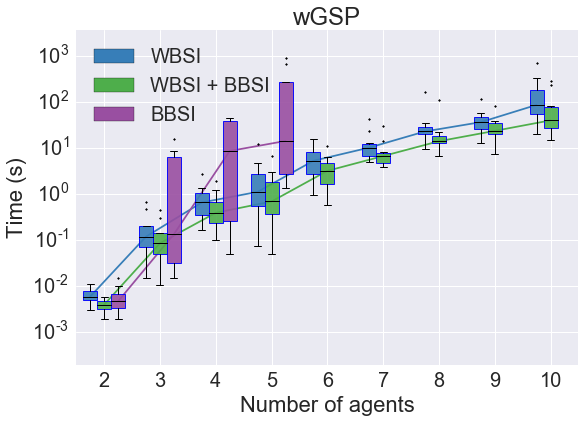

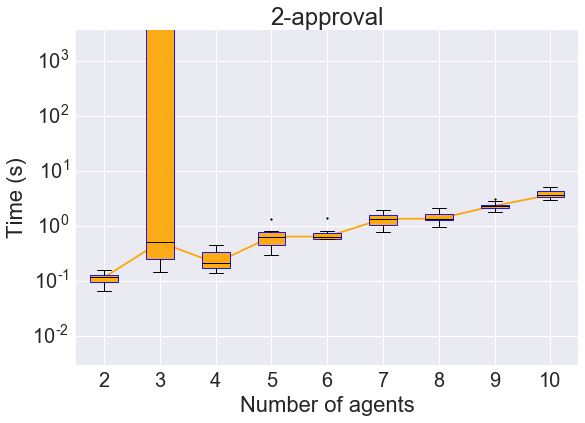

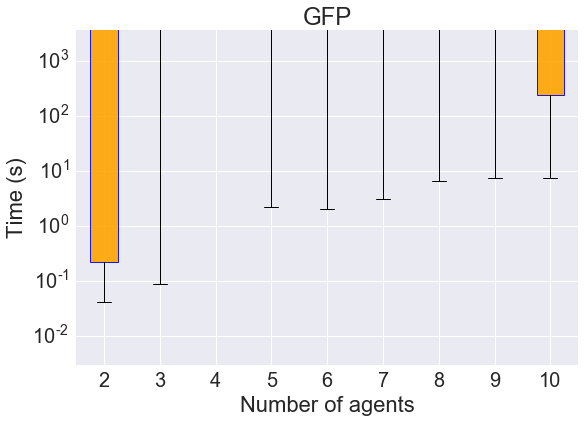

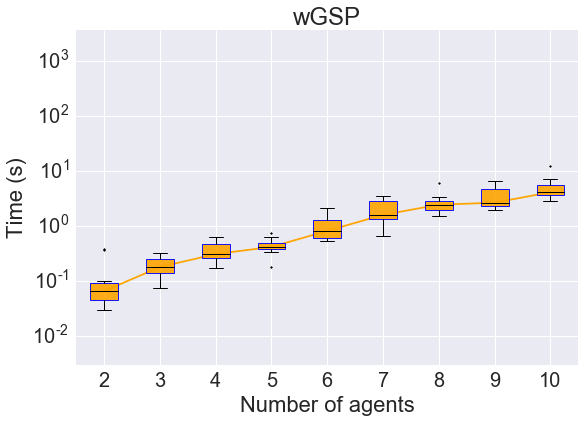

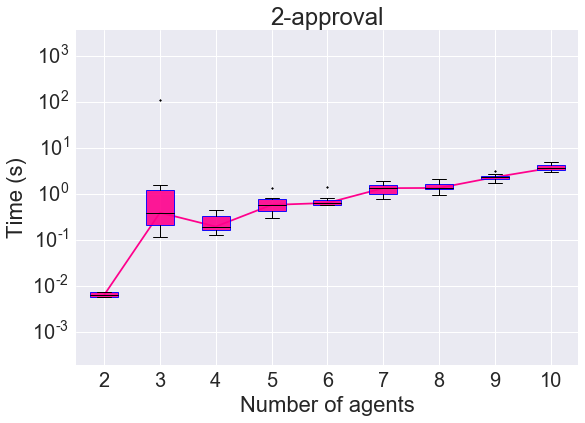

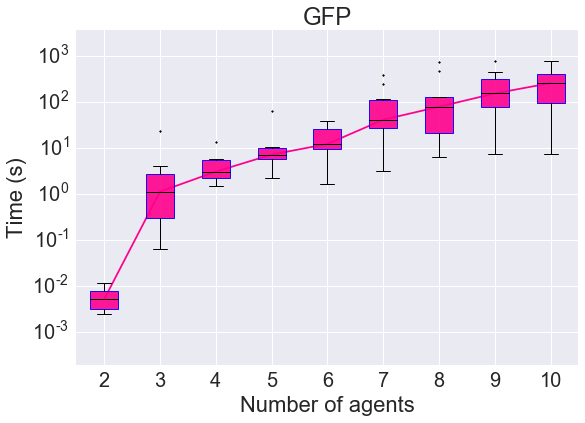

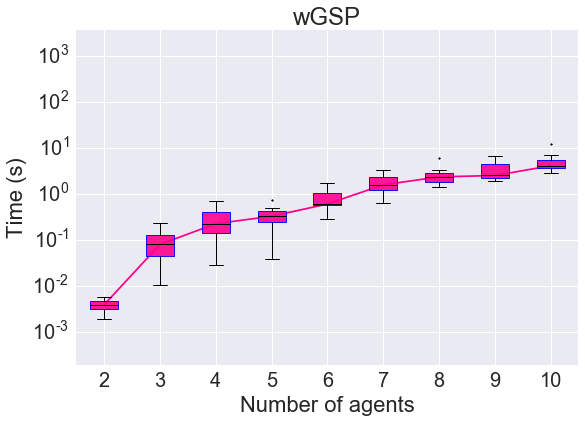

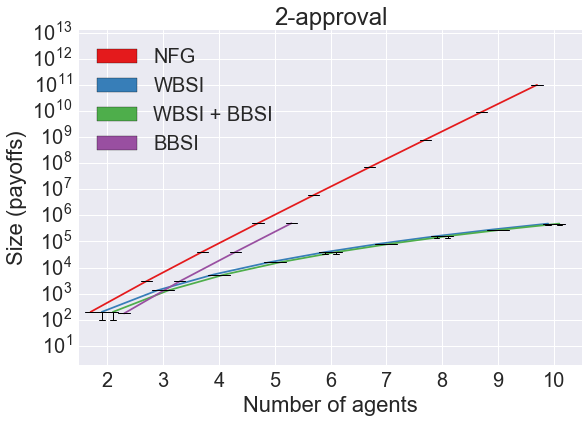

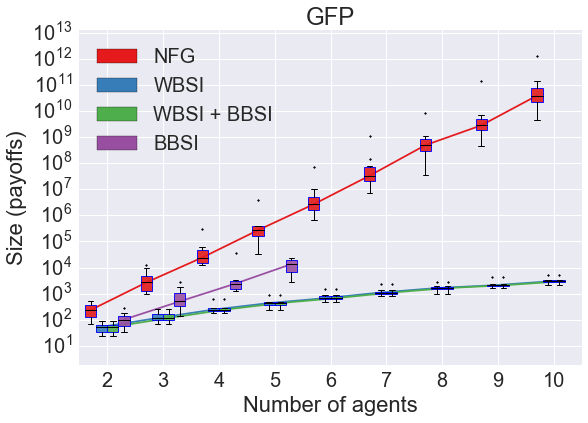

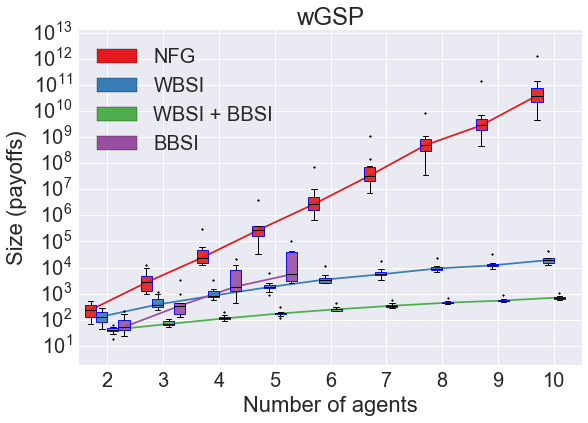

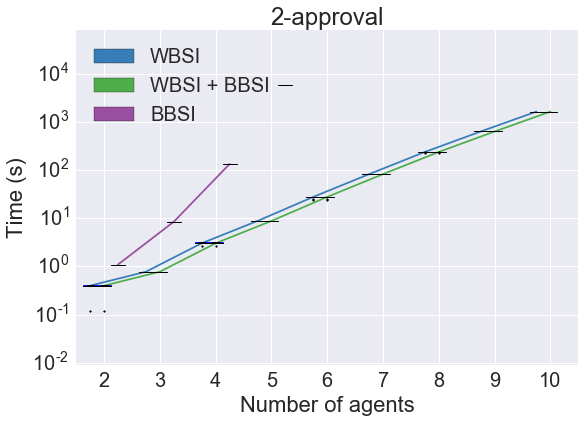

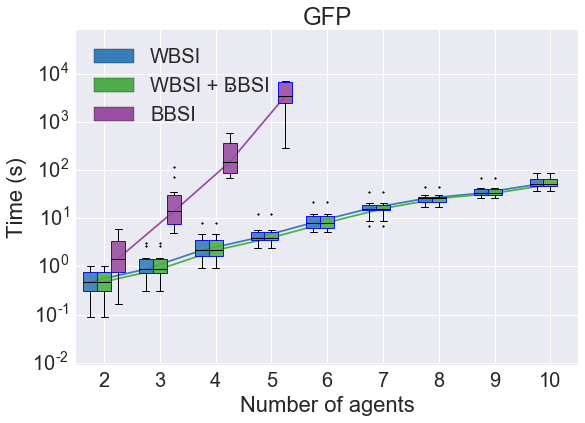

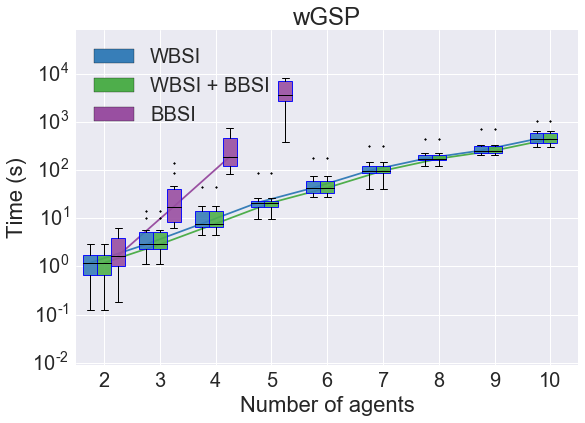

In [334]:
def custom_plot(df, metric=None, extra=None):
    highest = df['value'].max()
    lowest = df['value'].min()
    for game, game_group in df.groupby('game'):
        plt.figure(figsize=(9,6))              
        leg_entries = []
        if metric == 'runtime':
            order_copy = list(order)
            order_copy.remove('NFG')
        else:
            order_copy = order
        grouped = game_group.groupby('type')
        for i, t in enumerate(order_copy):
            try:
                group = grouped.get_group(t)
            except KeyError:
                continue
            if extra == 'ibr':
                color = 'orange'
            elif extra == 'Portfolio':
                color = '#ff008c'
            else:
                color = palette_dict[t]
            leg_entries.append((Rectangle((0, 0), 1, 1, fc=color), t))
            values = []
            positions = []
            medians_x = []
            medians_y = []
            for n in range(2,11):
                n_group = group[group[N] == n]
                if len(n_group) > 0:
                    data = n_group['value'].values
                    if metric == "runtime" and extra is not None:
                        if len(data) != 10:
                            print "WARN %s %s %s with %s players has %d data points!" % (extra, game, t, n, len(data))
                        timeouts = [d > 3600 for d in data]
                        if any(timeouts):
                            print "%d TIMEOUT for %s %s %s with %d players" % (sum(timeouts), extra, game, t, n)                    
                            if len(data) == 0:
                                continue
                    if extra == 'ibr' or extra == 'Portfolio':
                        pos = i * n
                        width = 0.5
                    else:
                        if len(order_copy) == 3:
                            width = 0.25
                            pos = -width + width * i+ n 
                        else:
                            width = 0.2
                            pos = -2*width + width * i + n + width/2
                    positions.append(pos)
                    values.append(data)
                    median = pd.Series(data).median()
                    if median > 3600 and metric == 'runtime':
                        pass
                    else:
                        medians_y.append(median)
                        medians_x.append(pos)
            plt.plot(medians_x, medians_y, color=color, zorder=1, linestyle='-')
            box = plt.boxplot(values, positions=positions, widths=[width]*len(values), 
                              patch_artist=True, whiskerprops={'linestyle':'-', 'color':'black'},
                              medianprops={'color':'black'}, manage_xticks=False,
                              sym='D', flierprops={'markerfacecolor':'black', 'markersize':2}
                             )
            for patch in box['boxes']:
                patch.set(facecolor=color, alpha=0.9)
        
        if metric == 'size':
            plt.ylabel('Size (payoffs)')
        else:
            plt.ylabel('Time (s)')
        plt.xlabel(N)
        plt.xlim(xmin=1.5,xmax=10.5)
        plt.xticks(np.arange(2,11,1))
        plt.yscale('log')
        plt.ylim(ymin=lowest / 10, ymax=highest*10 if extra is None else 3600)
        plt.title(game)
        if extra != 'ibr' and extra != 'Portfolio':
            artists, names = zip(*leg_entries)
            legend_location = 'upper left'
            if game == '2-approval' and extra == 'gnm':
                legend_location = 'lower right'
            plt.legend(artists, names, loc=legend_location)
        figname = 'figures/%s_%s.png' % (game, metric)
        if extra is not None:
            figname = 'figures/%s_%s_%s.png' % (game, extra, metric)
        print "saving", figname
        plt.savefig(figname, dpi=300)

custom_plot(gnm_melt, extra='gnm',metric='runtime')
custom_plot(ibr_melt, extra='ibr',metric='runtime')
custom_plot(portfolio_melt, extra='Portfolio', metric='runtime')

for metric in ['size', 'runtime']:
    d = df3[df3['metric'] == metric]
    if len(d) > 0:
        custom_plot(d, metric=metric)

687

In [327]:
# index_vars = ['n_players', 'gnm_seed', 'game', 'bagg_type', 'bad', 'cn'
# portfolio_melt = pd.merge(ibr_copy.set_index(index_vars), gnm_copy.set_index(index_vars), left_index=True, right_index=True, suffixes=['IBR', 'GNM'], how='inner')

portfolio = gnm[gnm['config'] == 'WBSI + BBSI'].copy()
new_vals = []
for row in portfolio.iterrows():
    row = row[1]
    runtime = row['runtime']
    ibr_row = ibr[(ibr['n_players'] == row['n_players']) & (ibr['gnm_seed'] == row['gnm_seed']) & (ibr['game'].str.lower() == row['game']) & (ibr['posec_seed'] == row['posec_seed'])]
    assert len(ibr_row) <= 1
    if len(ibr_row) == 1:
        rt = ibr_row['runtime'].values[0]
        runtime = min([rt, runtime])
    new_vals.append(runtime)
portfolio['runtime'] = new_vals
portfolio_melt = alg_runs_to_melt(portfolio)